## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from parse_preprocessed_data import get_inputs_and_targets
from LSTM_Model import LSTMModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyper-Parameters

In [2]:
#These hyper-paramters are identical to the Github's to test differences
seq_length = 50

hidden_size = 128
learning_rate = 2e-3
dropout = 0.5
batch_size = 100
num_layers = 3
max_epochs = 20
validation_prop = 0.2

## Load Data

In [3]:
#Not Original
char_to_ix, ix_to_char, vocab_size, inputs, targets = get_inputs_and_targets('data_preprocessed/mario.txt', seq_length)
vocab_size, inputs.shape, targets.shape

#vocab_size is 15
#inputs is (num_sequences, seq_length, vocab_size), and is one-hot encoded
#targets is (num_sequence, seq_length)

Unique chars: ['\n', '-', '<', '>', '?', 'B', 'E', 'Q', 'S', 'X', '[', ']', 'b', 'o', 'x']
Number of unique chars: 15


  0%|          | 0/37 [00:00<?, ?it/s]

(15, (124700, 50, 15), (124700, 50))

In [4]:
#Not Original
#This just saves the char_to_ix and ix_to_char to be used when generating the levels (irrelevent as its current in one file, but no harm in keeping)
#with open('data_preprocessed/char_to_ix.json', 'w+') as json_f:
#    json.dump(char_to_ix, json_f)

#with open('data_preprocessed/ix_to_char.json', 'w+') as json_f:
#    json.dump(ix_to_char, json_f)

In [5]:
#Convert the inputs and targets into tensors and load them into a dataset, then DataLoader
inputs_tensor = torch.tensor(inputs)
targets_tensor = torch.tensor(targets)

train_dataset = TensorDataset(inputs_tensor, targets_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Model

In [6]:
#Initialize model
model = LSTMModel(vocab_size, hidden_size, num_layers, dropout).to(device)

In [7]:
#Set the loss and optimizer functions
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train Model

In [8]:
#Train the model

#Lists to store loss and accuracy values for each epoch
loss_values = []
accuracy_values = []

for epoch in range(max_epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    
    for batch_inputs, batch_targets in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)

        #Clear gradients from previous iteration
        optimizer.zero_grad()
        
        #Forward pass
        outputs, _ = model(batch_inputs)
        
        #Reshape outputs and targets to have the same batch size
        outputs_flat = outputs.view(-1, outputs.size(-1))
        targets_flat = batch_targets.view(-1)
        
        #Calculate loss
        loss = criterion(outputs_flat, targets_flat.long())
        
        #Backward pass/ Compute gradients
        loss.backward()
        
        #Update weights
        optimizer.step()

        #Accumulate loss for the entire batch
        total_loss += loss.item() * batch_inputs.size(0)

        #Calculate accuracy for the batch
        _, predicted = torch.max(outputs, 2)
        correct = (predicted == batch_targets).sum().item()
        total_correct += correct
    
    #Calculate average loss and accuracy for the epoch
    epoch_loss = total_loss / len(train_loader.dataset)
    epoch_accuracy = total_correct / len(train_loader.dataset)

    #Stor loss and accuracy values to plot later
    loss_values.append(epoch_loss)
    accuracy_values.append(epoch_accuracy)
    
    #Print per-epoch loss and accuracy
    print(f'Epoch [{epoch+1}/{max_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

Epoch [1/20], Loss: 0.5508, Accuracy: 42.0022
Epoch [2/20], Loss: 0.3173, Accuracy: 45.1689
Epoch [3/20], Loss: 0.2839, Accuracy: 45.6151
Epoch [4/20], Loss: 0.2657, Accuracy: 45.8414
Epoch [5/20], Loss: 0.2548, Accuracy: 45.9834
Epoch [6/20], Loss: 0.2474, Accuracy: 46.0767
Epoch [7/20], Loss: 0.2419, Accuracy: 46.1540
Epoch [8/20], Loss: 0.2377, Accuracy: 46.2143
Epoch [9/20], Loss: 0.2344, Accuracy: 46.2588
Epoch [10/20], Loss: 0.2315, Accuracy: 46.3000
Epoch [11/20], Loss: 0.2288, Accuracy: 46.3413
Epoch [12/20], Loss: 0.2269, Accuracy: 46.3634
Epoch [13/20], Loss: 0.2246, Accuracy: 46.3950
Epoch [14/20], Loss: 0.2229, Accuracy: 46.4162
Epoch [15/20], Loss: 0.2214, Accuracy: 46.4380
Epoch [16/20], Loss: 0.2201, Accuracy: 46.4543
Epoch [17/20], Loss: 0.2187, Accuracy: 46.4749
Epoch [18/20], Loss: 0.2177, Accuracy: 46.4898
Epoch [19/20], Loss: 0.2167, Accuracy: 46.5003
Epoch [20/20], Loss: 0.2155, Accuracy: 46.5183


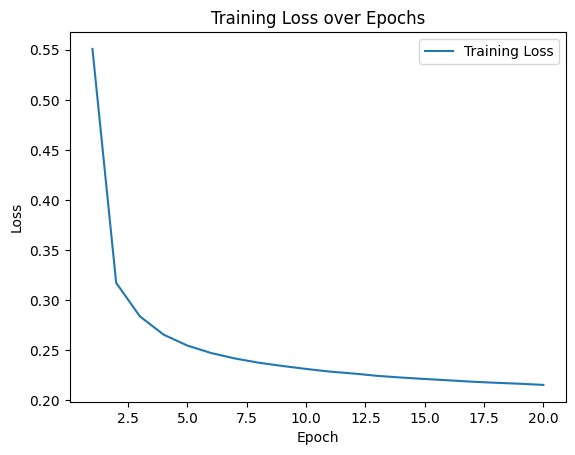

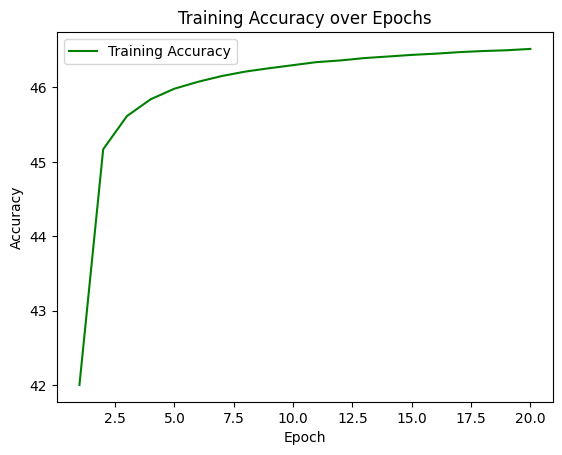

In [9]:
#Plot training loss over epochs
plt.plot(range(1, max_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

#Plot training accuracy over epochs
plt.plot(range(1, max_epochs + 1), accuracy_values, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()

## Generate Levels

In [10]:
#Not Original

#'seed' is a starting one-hot encoded sequence used as the beginning of each level
seed = np.loadtxt('data_preprocessed/seed.txt', dtype=float)[:3*17 - 1].copy()

#Load the ix_to_char and char_to_ix from the file (even though it was already declared above)
#with open('data_preprocessed/ix_to_char.json', 'r') as json_f:
#    ix_to_char = json.load(json_f)
    
#with open('data_preprocessed/char_to_ix.json', 'r') as json_f:
#    char_to_ix = json.load(json_f)

In [13]:
#Not Original

#Converts the one-hot output of the model into a string
def onehot_to_string(onehot):
    ints = np.argmax(onehot, axis=-1)
    chars = [ix_to_char[ix] for ix in ints]
    string = "".join(chars)
    char_array = []
    for line in string.rstrip().split('\n')[:-1]:
        if len(line) == 16:
            char_array.append(list(line))
        elif len(line) > 16:
            char_array.append(list(line[:16]))
        elif len(line) < 16:
            char_array.append(['-'] * (16 - len(line)) + list(line))
    char_array = np.array(char_array).T
    string = ""
    for row in char_array:
        string += "".join(row) + "\n"
    return string

In [14]:
#Not Original

seed[17+14] = 0
seed[17+14][char_to_ix['x']] = 1
seed[17*2+14] = 0
seed[17*2+14][char_to_ix['x']] = 1
#The seed in its one-hot form
print(seed)
#The seed in its character form
print(onehot_to_string(seed))

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [15]:
#Not Original

#Returns a copy of the seed in its one-hot encoded form
def get_seed():
    seed = np.loadtxt('data_preprocessed/seed.txt', dtype=float)[:3*17 - 1]
    seed[17+14] = 0
    seed[17+14][char_to_ix['x']] = 1
    seed[17*2+14] = 0
    seed[17*2+14][char_to_ix['x']] = 1
    return seed

In [16]:
#Not Original
num_levels_to_gen = 10
num_chunks = 10
num_cols_per_chunk = 16
num_rows_per_col = 17
#Calcuates the number of characters needed to generate a num
num_chars_to_gen = num_chunks * num_cols_per_chunk * num_rows_per_col - len(seed)
print(num_chars_to_gen)

2670


In [19]:
#Initialize empty array to hold generated levels
gen = []

for i in range(num_levels_to_gen):
    
    #Seed initialization
    seed = torch.from_numpy(get_seed()).type(torch.Tensor).to(device)
    
    #Initialize empty array to hold generated level sequence
    generated_seq = []
    
    #Initialize hidden states to be empty
    h0 = torch.zeros(num_layers, 1, hidden_size).to(device)
    c0 = torch.zeros(num_layers, 1, hidden_size).to(device)
    
    #Generate each character in the level
    for j in range(num_chars_to_gen):
        #Forward pass through the model
        output, (h0, c0) = model(seed.view(1, -1, vocab_size), (h0, c0))
        #Get the softmax probabilties of each tile
        output_probs = F.softmax(output, dim=-1).squeeze().cpu().detach().numpy()
    
        #Sample the next character, convert it to an actual char and add it to the end of the generated sequence
        next_char_idx = np.random.choice(vocab_size, p=output_probs[-1])
        next_char = ix_to_char[next_char_idx]
        generated_seq.append(next_char)
        
        #Add the new char to the seed for the next iteration
        next_char_tensor = torch.tensor(next_char_idx).to(device)
        one_hot_tensor = F.one_hot(next_char_tensor, num_classes=vocab_size).unsqueeze(0).to(device)
        seed = torch.cat((seed[1:].to(device), one_hot_tensor), dim=0)
        
    #Convert generated sequence to a string, then add the new level to the generated level array
    gen.append(''.join(generated_seq))


In [28]:
#Sample of the first level's generated sequence
print(gen[0])


----------S---xX
----------S---xX
----------S---xX
----------S---xX
----------S---xX
----------S---xX
----------S---xX
----------S---xX
----------S---xX
---------oS--xxX
---------oX--xx-
---------o---x---
-------------x--
--------------xX
--------------xX
-------------xxX
------------xx--
-----------xx---
-----------x----
------------x-S-
-------------x--
--------------xX
--------------xX
--------------xX
-------------xxX
------------xx-X
-----------xx--X
-----------xQ--X
-----------x----
-----------x----
-----------x<[[X
----------xx>]]X
----------x----X
----------x----X
-----------x-XXX
------------x--X
-------------xEX
--------------xX
--------------xX
--------------xX
--------------xX
--------------xX
--------------xX
-----------?--xX
-----------Q--xX
-----------Q--xX
--------------xX
--------------xX
-------------xxX
-------------xEX
----------S--x-X
----------S---xX
-------S-----xxX
-------S-----x--
-------------x--
-------------x-X
-------------x--
-------------x-X
------------

In [29]:
#The generated sequence is full of unhelpful \n and is rotated unhelpfuly, this formats it correctly
modified_gen = []
for i in range(len(gen)):
    rows = gen[i].split('\n')[1:-1]
    for r in range(len(rows)):
        row = rows[r]
        #Pad the row with 'x' until it reaches length 16
        rows[r] = row.ljust(16, 'x')
    new_string = ''
    for j in range(16):
        new_string = new_string + ''.join([row[j] for row in rows])
        if j < 15:
            new_string += '\n'
    modified_gen.append(new_string)

In [30]:
#Sample of the corrected first level's generated sequence
print(modified_gen[0])

------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------xxx--xxx------------
---------------------------------------------------------------------------------------------------------------------------------------xx--xxx--x-----------
----------------------------------------------------------

In [31]:
#Not Original

#Saves all of the generated levels to a file
for i, g in enumerate(modified_gen):
    with open(f'generated_levels_txt/{i+1}.txt', 'w+') as txt_f:
        txt_f.write(g)